# Optimal Optimizer
Comparing SGD vs Adam Optimizer vs. Nadam

### Model
- model = LSTM
- batch_size = 32
- epochs = 100
- loss = mse


### Data
- time frame: 6 months | 6 months
- features: all of them (110)
- target: EDSS_6...EDSS_222
- imputation 
    - target: interpolation (last known value for trailing ends)
    - features: zero-imputation
- time steps: exhaustive (37)

In [48]:
from __future__ import print_function
import pandas as pd
import numpy as np
import time
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import sklearn as sk
from matplotlib import pyplot as plt

import keras.layers as L
import keras.models as M


def select_columns(col_list, n_months):
    """
    Takes in a list of column names and number of visits starting at 0.
    Returns column list time-stepped and dovetailed.
    """ 
    return dovetail_names(*[time_step_names(i, n_months) for i in col_list])
        
def time_step_names(name, n_months):

    return [(name + '_%d' % (j+1)) for j in range(-1,n_months*6, 6)]

def dovetail_names(*kwargs):
    """
    Dovetails column names across time slices cccording to preset order.
    """
    zipped = zip(*kwargs)
    l = []
   
    for i in zipped:
        
        for j in i:
            
            l.append(j)
            
    return l

def stack_times(data, name, n):
    """
    Takes in wide-format dataframe, column name and n of time steps.
    Returns long-foramt dataframe.
    """
    all_names = select_columns(name, n-1)
    
    l = []
    
    for col in all_names:
        
        l.append(data[col].copy())
    
    stacked = l[0]
    rest = l[1:]

    stacked.append(rest) # Stack Series and get dummy variables 
    
    return stacked

def stack_dummy(data, name, n):
    """
    Takes in dataframe and column name.
    Returns that same feature split into dummy columns
    across n time steps (adjacent).
    """
    all_names = select_columns(name, n-1)
    
    l = []
    
    for col in all_names:
        
        l.append(data[col].copy())
    
    f = l[0]
    rest = l[1:]
    
    pre_dummy = pd.get_dummies(f.append(rest)) # Stack Series and get dummy variables 
    after_dummy = time_dummy(pre_dummy, n)
    
    dummy_value_names = generate_col_names(after_dummy, name)
    time_stepped_dummy_names = time_step_dummy_value_names(dummy_value_names, n)
    
    for t in range(len(after_dummy)):
        
        after_dummy[t].columns = list(time_stepped_dummy_names[t])
        
    return pd.concat(after_dummy, axis = 1, sort = False), dummy_value_names


def time_dummy(dummy_df, n):
    """
    Separates long data frame into time steps 
    (i.e. 508 subjects (rows) per time step)
    """
    l = []
    
    for i in range(n):
        
        l.append(dummy_df.iloc[i*508:(i+1)*508,:].copy())
    
    return l

def generate_col_names(after_dummy, name):
    """
    Generates column names for result of pd.get_dummies on a feature
    i.e. if A has values x and y, it will generate A_x, A_y
    """
    return [(str(name[0]) + "_" + str(list(after_dummy[0].columns)[i])) 
            for i in range(len(list(after_dummy[0].columns)))]

def time_step_dummy_value_names(names, n_months):
    
    long_list = [(name + '_%d' % (j+1)) for j in range(-1,n_months*6, 6) for name in names]
    
    return np.array(long_list).reshape(-1, len(names))

def add_columns(add_to, name, names_per_t, n):
    """
    Adds new dummied features to dataframes (copies).
    
    Removes undummied version of features.
    
    Function wraps around stack_dummy() function.
    
    Argument "name" must be a list dtype. 
    """
    n = n + 1
    to_add, bare_names = stack_dummy(df, name, n)
    to_remove = select_columns(name, n-1)
    
    newdf = add_to.copy()
    column_names = list(to_add.columns)
    
    for i in range(len(column_names)):
        
        newdf[column_names[i]] = to_add.iloc[:,i]
        
    newdf.drop(to_remove,axis = 1, inplace = True)
    names_per_t_updated = column_names_per_time_step(names_per_t, bare_names, name[0])
    namesOrder= select_columns(names_per_t_updated, n-1)
    
    return newdf[namesOrder].copy(), names_per_t_updated

def column_names_per_time_step(original_list, add, remove):
    """
    Places EDSS column at the end of the time slice
    Removes previous
    """
    new_list = original_list.copy()

    new_list.remove(remove)
    new_list.extend(add)
    
    new_list.remove('EDSS')
    new_list.append('EDSS')
    
    return new_list

def manual_dummy(df, names, name_list, n):
    
    dfUpdated =df.copy()
    
    names = [[name] for name in names] # turn to list format 
    
    for name in names:
        
        dfUpdated, name_list = add_columns(dfUpdated, name , name_list, n)
   
    return dfUpdated 

# IMPORT DATA & DEFINE N OF TIME STEPS

In [3]:
X = pd.read_csv("../data/X_6_months|6_months_exhaustive.csv", index_col = 0)
y = pd.read_csv("../data/y_6_months|6_months_exhaustive.csv", index_col = 0)

n_time_steps = len(y.columns)
n_inputs_pure = X.columns.tolist().index("EDSS_0")+1

pot = 1
print("The RNN window will slide", n_time_steps, "times")
print("The input length of the training data will be", pot, "time slices, separated by 6 month intervals")
print("There will be", n_inputs_pure, "per time step")

The RNN window will slide 37 times
The input length of the training data will be 1 time slices, separated by 6 month intervals
There will be 110 per time step


# Split into train and test

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=1)

X_train_reshaped = X_train.values.reshape(-1, n_time_steps, n_inputs_pure) # extra time step for stretch
y_train_reshaped = y_train.values.reshape(-1, n_time_steps, 1)
print("X reshaped is " + str(X_train_reshaped.shape))
print("y reshaped is " + str(y_train_reshaped.shape))

X_test_reshaped = X_test.values.reshape(-1, n_time_steps, n_inputs_pure)
y_test_reshaped = y_test.values.reshape(-1, n_time_steps, 1)
print("X reshaped is " + str(X_test_reshaped.shape))
print("y reshaped is " + str(y_test_reshaped.shape))

y_train = y_train_reshaped.astype(float)
y_test = y_test_reshaped.astype(float)
X_train = X_train_reshaped.astype(float)
X_test = X_test_reshaped.astype(float)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

X reshaped is (355, 37, 110)
y reshaped is (355, 37, 1)
X reshaped is (153, 37, 110)
y reshaped is (153, 37, 1)
(355, 37, 110) (355, 37, 1) (153, 37, 110) (153, 37, 1)


# Set values for the neuron

In [6]:
n_inputs = n_inputs_pure * pot

n_units = 64

n_output = 1

learning_rate = 0.01

print(n_inputs, "inputs per time step (",n_time_steps,") comprising", pot, "time slice,", n_inputs_pure, "features each")

110 inputs per time step ( 37 ) comprising 1 time slice, 110 features each


### SGD Optimizer 

In [8]:
model_sgd = M.Sequential()

# Each input data point has 37 timesteps, each with 110 features.
# So the input shape (excluding batch_size) is (37, 110)

model_sgd.add(L.LSTM(64, input_shape=(n_time_steps, n_inputs), return_sequences=True))
model_sgd.add(L.Dense(n_output, activation='linear'))
model_sgd.compile(optimizer = 'sgd', loss = 'mean_squared_error')

history_sgd = model_sgd.fit(X_train, y_train, batch_size = 32, 
                              epochs=100, validation_data=(X_test, y_test), 
                              shuffle=True)

Train on 355 samples, validate on 153 samples
Epoch 1/100
355/355 [==============================] - 3s 7ms/step - loss: 3.2053 - val_loss: 5.0773
Epoch 2/100
355/355 [==============================] - 1s 3ms/step - loss: 1.9604 - val_loss: 1.9688
Epoch 3/100
355/355 [==============================] - 1s 3ms/step - loss: 0.9012 - val_loss: 1.2591
Epoch 4/100
355/355 [==============================] - 1s 3ms/step - loss: 0.6569 - val_loss: 0.9905
Epoch 5/100
355/355 [==============================] - 1s 3ms/step - loss: 0.5615 - val_loss: 1.2034
Epoch 6/100
355/355 [==============================] - 1s 3ms/step - loss: 0.5832 - val_loss: 0.9234
Epoch 7/100
355/355 [==============================] - 1s 3ms/step - loss: 0.5199 - val_loss: 1.2063
Epoch 8/100
355/355 [==============================] - 1s 3ms/step - loss: 0.5956 - val_loss: 0.7713
Epoch 9/100
355/355 [==============================] - 1s 3ms/step - loss: 0.4442 - val_loss: 0.8339
Epoch 10/100
355/355 [=======================

Epoch 81/100
355/355 [==============================] - 1s 4ms/step - loss: 0.2705 - val_loss: 0.3577
Epoch 82/100
355/355 [==============================] - 1s 4ms/step - loss: 0.2683 - val_loss: 0.3580
Epoch 83/100
355/355 [==============================] - 1s 3ms/step - loss: 0.2683 - val_loss: 0.3579
Epoch 84/100
355/355 [==============================] - 1s 4ms/step - loss: 0.2677 - val_loss: 0.3548
Epoch 85/100
355/355 [==============================] - 1s 3ms/step - loss: 0.2694 - val_loss: 0.3623
Epoch 86/100
355/355 [==============================] - 1s 4ms/step - loss: 0.2678 - val_loss: 0.3602
Epoch 87/100
355/355 [==============================] - 1s 4ms/step - loss: 0.2680 - val_loss: 0.3519
Epoch 88/100
355/355 [==============================] - 1s 3ms/step - loss: 0.2662 - val_loss: 0.3527
Epoch 89/100
355/355 [==============================] - 1s 4ms/step - loss: 0.2658 - val_loss: 0.3547
Epoch 90/100
355/355 [==============================] - 1s 3ms/step - loss: 0.2657

In [ ]:
mse_test_sgd = history_sgd.__dict__['history']['val_loss']
mse_train_sgd = history_sgd.__dict__['history']['loss']
sgd_params = history_sgd.__dict__['params']

### Adam Optimizer

In [7]:
model_adam = M.Sequential()

# Each input data point has 37 timesteps, each with 110 features.
# So the input shape (excluding batch_size) is (37, 110)

model_adam.add(L.LSTM(n_units, input_shape=(n_time_steps, n_inputs), return_sequences=True))
model_adam.add(L.Dense(n_output, activation='linear'))
model_adam.compile(optimizer = 'adam', loss = 'mean_squared_error')

history_adam = model_adam.fit(X_train, y_train, batch_size = 32, 
                              epochs=100, validation_data=(X_test, y_test), 
                              shuffle=True)

Train on 355 samples, validate on 153 samples
Epoch 1/100
355/355 [==============================] - 3s 8ms/step - loss: 5.1878 - val_loss: 5.3224
Epoch 2/100
355/355 [==============================] - 1s 3ms/step - loss: 3.3150 - val_loss: 4.4308
Epoch 3/100
355/355 [==============================] - 1s 3ms/step - loss: 2.6347 - val_loss: 3.7467
Epoch 4/100
355/355 [==============================] - 1s 3ms/step - loss: 1.9253 - val_loss: 2.6690
Epoch 5/100
355/355 [==============================] - 1s 3ms/step - loss: 1.2012 - val_loss: 1.8441
Epoch 6/100
355/355 [==============================] - 1s 3ms/step - loss: 0.8305 - val_loss: 1.3664
Epoch 7/100
355/355 [==============================] - 1s 3ms/step - loss: 0.6428 - val_loss: 1.1701
Epoch 8/100
355/355 [==============================] - 1s 3ms/step - loss: 0.5550 - val_loss: 1.0726
Epoch 9/100
355/355 [==============================] - 1s 3ms/step - loss: 0.5045 - val_loss: 1.0037
Epoch 10/100
355/355 [=======================

Epoch 81/100
355/355 [==============================] - 1s 4ms/step - loss: 0.2061 - val_loss: 0.3488
Epoch 82/100
355/355 [==============================] - 1s 3ms/step - loss: 0.2061 - val_loss: 0.3384
Epoch 83/100
355/355 [==============================] - 1s 4ms/step - loss: 0.2045 - val_loss: 0.3453
Epoch 84/100
355/355 [==============================] - 1s 4ms/step - loss: 0.2020 - val_loss: 0.3465
Epoch 85/100
355/355 [==============================] - 1s 3ms/step - loss: 0.2050 - val_loss: 0.3445
Epoch 86/100
355/355 [==============================] - 1s 4ms/step - loss: 0.2054 - val_loss: 0.3456
Epoch 87/100
355/355 [==============================] - 1s 3ms/step - loss: 0.2073 - val_loss: 0.3437
Epoch 88/100
355/355 [==============================] - 1s 4ms/step - loss: 0.1991 - val_loss: 0.3411
Epoch 89/100
355/355 [==============================] - 1s 3ms/step - loss: 0.1971 - val_loss: 0.3421
Epoch 90/100
355/355 [==============================] - 1s 4ms/step - loss: 0.1967

In [ ]:
mse_test_adam = history_adam.__dict__['history']['val_loss']
mse_train_adam = history_adam.__dict__['history']['loss']
adam_params = history_adam.__dict__['params']

# Nadam Optimizer

In [8]:
model_nadam = M.Sequential()

# Each input data point has 37 timesteps, each with 110 features.
# So the input shape (excluding batch_size) is (37, 110)

model_nadam.add(L.LSTM(n_units, input_shape=(n_time_steps, n_inputs), return_sequences=True))
model_nadam.add(L.Dense(n_output, activation='linear'))
model_nadam.compile(optimizer = 'nadam', loss = 'mean_squared_error')

history_nadam = model_nadam.fit(X_train, y_train, batch_size = 32, 
                              epochs=100, validation_data=(X_test, y_test), 
                              shuffle=True)

Train on 355 samples, validate on 153 samples
Epoch 1/100
355/355 [==============================] - 3s 8ms/step - loss: 3.6600 - val_loss: 3.1609
Epoch 2/100
355/355 [==============================] - 1s 3ms/step - loss: 1.2174 - val_loss: 1.3742
Epoch 3/100
355/355 [==============================] - 1s 3ms/step - loss: 0.6709 - val_loss: 1.0458
Epoch 4/100
355/355 [==============================] - 1s 3ms/step - loss: 0.5286 - val_loss: 0.8062
Epoch 5/100
355/355 [==============================] - 1s 3ms/step - loss: 0.4403 - val_loss: 1.0075
Epoch 6/100
355/355 [==============================] - 1s 3ms/step - loss: 0.4659 - val_loss: 0.6155
Epoch 7/100
355/355 [==============================] - 1s 3ms/step - loss: 0.3653 - val_loss: 0.5939
Epoch 8/100
355/355 [==============================] - 1s 3ms/step - loss: 0.3720 - val_loss: 0.5454
Epoch 9/100
355/355 [==============================] - 1s 3ms/step - loss: 0.3336 - val_loss: 0.5135
Epoch 10/100
355/355 [=======================

Epoch 81/100
355/355 [==============================] - 1s 4ms/step - loss: 0.1640 - val_loss: 0.3245
Epoch 82/100
355/355 [==============================] - 1s 4ms/step - loss: 0.1645 - val_loss: 0.3269
Epoch 83/100
355/355 [==============================] - 1s 4ms/step - loss: 0.1608 - val_loss: 0.3359
Epoch 84/100
355/355 [==============================] - 1s 4ms/step - loss: 0.1656 - val_loss: 0.3408
Epoch 85/100
355/355 [==============================] - 1s 4ms/step - loss: 0.1590 - val_loss: 0.3399
Epoch 86/100
355/355 [==============================] - 1s 4ms/step - loss: 0.1611 - val_loss: 0.3525
Epoch 87/100
355/355 [==============================] - 1s 3ms/step - loss: 0.1624 - val_loss: 0.4222
Epoch 88/100
355/355 [==============================] - 1s 4ms/step - loss: 0.1836 - val_loss: 0.3606
Epoch 89/100
355/355 [==============================] - 1s 4ms/step - loss: 0.1601 - val_loss: 0.3569
Epoch 90/100
355/355 [==============================] - 1s 4ms/step - loss: 0.1526

In [9]:
mse_test_nadam = history_nadam.__dict__['history']['val_loss']
mse_train_nadam = history_nadam.__dict__['history']['loss']
nadam_params = history_nadam.__dict__['params']

# Train MSE

Best Train Scores

SGD Score: 0.26153172808633723
Epoch: 98

Adam Score: 0.1862020033346096
Epoch: 99

Nadam Score: 0.14555565727428652
Epoch: 99


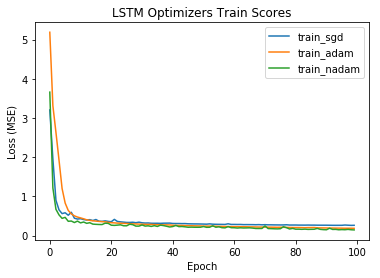

In [43]:
plt.plot(mse_train_sgd)
plt.plot(mse_train_adam)
plt.plot(mse_train_nadam)

plt.title('LSTM Optimizers Train Scores')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')

plt.legend(['train_sgd','train_adam','train_nadam'])

print("Best Train Scores\n")

print("SGD Score:", np.min(mse_train_sgd))
print("Epoch:",np.argmin(mse_train_sgd))

print("\nAdam Score:", np.min(mse_train_adam))
print("Epoch:",np.argmin(mse_train_adam))


print("\nNadam Score:", np.min(mse_train_nadam))
print("Epoch:",np.argmin(mse_train_nadam))

# Test MSE

Best Test Scores 

SGD Score: 0.3448968284270343
Epoch: 91

Adam Score: 0.33840388157009305
Epoch: 81

Nadam Score: 0.32448095005322125
Epoch: 80


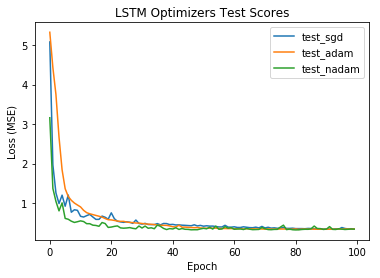

In [55]:
plt.plot(mse_test_sgd)
plt.plot(mse_test_adam)
plt.plot(mse_test_nadam)
plt.title('LSTM Optimizers Test Scores')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')

plt.legend(['test_sgd','test_adam', 'test_nadam'])

print("Best Test Scores \n")
print("SGD Score:", np.min(mse_test_sgd))
print("Epoch:", np.argmin(mse_test_sgd))

print("\nAdam Score:", np.min(mse_test_adam))
print("Epoch:", np.argmin(mse_test_adam))

print("\nNadam Score:", np.min(mse_test_nadam))
print("Epoch:", np.argmin(mse_test_nadam))

# Train RMSE

Best Train Scores

SGD Score: 0.5114017286696803
Epoch: 98

Adam Score: 0.4315113015143515
Epoch: 99

Nadam Score: 0.3815175713833984
Epoch: 99


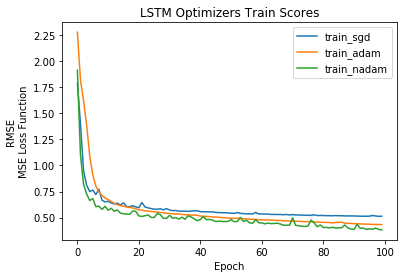

In [73]:
rmse_train_sgd = np.sqrt(mse_train_sgd)
rmse_train_adam = np.sqrt(mse_train_adam)
rmse_train_nadam = np.sqrt(mse_train_nadam)

plt.plot(rmse_train_sgd)
plt.plot(rmse_train_adam)
plt.plot(rmse_train_nadam)

plt.title('LSTM Optimizers Train Scores')
plt.xlabel('Epoch')
plt.ylabel('RMSE \nMSE Loss Function')

plt.legend(['train_sgd','train_adam','train_nadam'])

print("Best Train Scores\n")

print("SGD Score:", np.min(rmse_train_sgd))
print("Epoch:",np.argmin(rmse_train_sgd))

print("\nAdam Score:", np.min(rmse_train_adam ))
print("Epoch:",np.argmin(rmse_train_adam ))


print("\nNadam Score:", np.min(rmse_train_nadam))
print("Epoch:",np.argmin(rmse_train_nadam))

# Train RMSE

Best Train Scores

SGD Score: 0.5872791741812698
Epoch: 91

Adam Score: 0.5817249191586115
Epoch: 81

Nadam Score: 0.5696322937239613
Epoch: 80


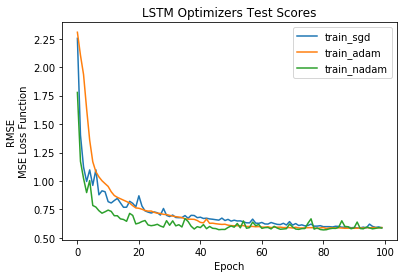

In [72]:
rmse_test_sgd = np.sqrt(mse_test_sgd)
rmse_test_adam = np.sqrt(mse_test_adam)
rmse_test_nadam = np.sqrt(mse_test_nadam)

plt.plot(rmse_test_sgd)
plt.plot(rmse_test_adam)
plt.plot(rmse_test_nadam)

plt.title('LSTM Optimizers Test Scores')
plt.xlabel('Epoch')
plt.ylabel('RMSE \nMSE Loss Function')

plt.legend(['train_sgd','train_adam','train_nadam'])

print("Best Train Scores\n")

print("SGD Score:", np.min(rmse_test_sgd))
print("Epoch:",np.argmin(rmse_test_sgd))

print("\nAdam Score:", np.min(rmse_test_adam ))
print("Epoch:",np.argmin(rmse_test_adam ))


print("\nNadam Score:", np.min(rmse_test_nadam))
print("Epoch:",np.argmin(rmse_test_nadam))

In [46]:
# LSTM_df = pd.concat([
# pd.DataFrame(mse_test_sgd, columns=['SGD Test MSE']),
# pd.DataFrame(mse_test_adam, columns=['Adam Test MSE']),
# pd.DataFrame(mse_test_nadam, columns=['Nadam Test MSE']),
# pd.DataFrame(mse_train_sgd, columns=['SGD Train MSE']),
# pd.DataFrame(mse_train_adam, columns=['Adam Train MSE']),
# pd.DataFrame(mse_train_nadam, columns=['Nadam Train MSE'])
# ], axis = 1)

In [47]:
# LSTM_df.to_csv('LSTM_df_parametrization.csv')